# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                   
Sample_084  A0A087WWA5                          13.183
Sample_137  P48723                              15.952
Sample_071  P01008                              21.386
Sample_177  P01834                              26.639
Sample_162  A0A0A0MSC4;H7BYW6;P04085;P04085-2   17.974
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                          
Sample_162  P62736                                     14.718
Sample_145  Q05996;Q05996-2                            13.572
Sample_150  O95297;O95297-2;O95297-3;O95297-4;Q9UEL6   13.562
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.556
            A0A075B6Q5                 13.226
            A0A075B6R2                 12.341
            A0A075B6S5                 13.348
            A0A087WSY4                 12.559
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.546
            Q9UI40;Q9UI40-2            12.266
            Q9UIW2                     13.590
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.519
            Q9UP79                     12.891
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.940,15.050,16.842,19.863,13.258,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.116,19.067,...,15.528,15.576,12.990,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.851,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.597,17.705,17.039,12.476,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.399,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,13.219,15.345,17.084,18.708,14.249,19.433,9.567,9.034
Sample_207,15.739,16.877,15.469,16.898,12.735,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.556,...,16.012,15.178,12.307,15.050,16.842,19.863,13.936,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.876,19.067,16.188,...,15.528,15.576,13.034,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.500,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.523,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.430,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.269,15.345,17.084,18.708,14.249,19.433,13.809,13.436
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 368.76it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.89it/s]

100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.83it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  3.88it/s]

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.53it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.47it/s]

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.78it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.76it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.17it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.19it/s]

100%|██████████| 6/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.16it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.11it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.45it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.28it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.83it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.40it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.22it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.55it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.10it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.66it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.55it/s]

100%|██████████| 8/8 [00:02<00:00,  2.55it/s]

100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.50it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.71it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.08it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.01it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  3.00it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.56it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.38it/s]

100%|██████████| 9/9 [00:03<00:00,  2.26it/s]

100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.52it/s]

 30%|███       | 3/10 [00:00<00:01,  3.98it/s]

 40%|████      | 4/10 [00:01<00:01,  3.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.22it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.10it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.07it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.98it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  2.39it/s]

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.20it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.37it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.88it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.55it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.29it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.15it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.07it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  2.00it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.86it/s]

100%|██████████| 11/11 [00:05<00:00,  1.82it/s]

100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.03it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.78it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.35it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.98it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.97it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.87it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.95it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.95it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.28it/s]

100%|██████████| 12/12 [00:04<00:00,  2.20it/s]

100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.24it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.74it/s]

 31%|███       | 4/13 [00:01<00:03,  2.64it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.37it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.29it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.16it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.09it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.29it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.04it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.97it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.96it/s]

100%|██████████| 13/13 [00:05<00:00,  2.07it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.12it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.09it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.63it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.37it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.09it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.92it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.76it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.64it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.24it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.04it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.93it/s]

100%|██████████| 14/14 [00:05<00:00,  1.88it/s]

100%|██████████| 14/14 [00:05<00:00,  2.49it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.42it/s]

 20%|██        | 3/15 [00:00<00:03,  3.63it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.15it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.07it/s]

 40%|████      | 6/15 [00:01<00:02,  3.05it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:02<00:03,  2.19it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.11it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.94it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.82it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.70it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.66it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.75it/s]

100%|██████████| 15/15 [00:06<00:00,  1.87it/s]

100%|██████████| 15/15 [00:06<00:00,  2.14it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.067 0.023          0.724 0.383       0.100   
2             0.004 0.003      0.055 0.015          0.723 0.100       0.557   
3             0.005 0.004      0.068 0.025          0.772 0.109       0.711   
4             0.005 0.004      0.069 0.027          0.767 0.098       0.730   
5             0.005 0.004      0.074 0.025          0.813 0.090       0.744   
6             0.005 0.003      0.061 0.021          0.817 0.093       0.774   
7             0.005 0.006      0.072 0.026          0.817 0.094       0.779   
8             0.005 0.003      0.060 0.020          0.812 0.093       0.782   
9             0.005 0.004      0.062 0.021          0.822 0.088       0.845   
10            0.005 0.004      0.059 0.019          0.820 0.086       0.835   
11            0.005 0.003      0.065 0.024          0.825 0.079       0.821   
12            0.008 0.006      0.079 0.032          0.822 0.079       0.822   
13            0.006 0.005      0.063 0.026          0.815 0.080       0.811   
14            0.006 0.004      0.067 0.030          0.810 0.083       0.805   
15            0.004 0.001      0.057 0.019          0.809 0.079       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.169 0.122                  0.543 0.038        0.861   
2          0.116   0.622 0.091                  0.698 0.063        0.798   
3          0.118   0.733 0.086                  0.775 0.069        0.873   
4          0.119   0.742 0.084                  0.781 0.067        0.883   
5          0.100   0.772 0.074                  0.807 0.061        0.902   
6          0.092   0.791 0.072                  0.822 0.060        0.910   
7          0.090   0.793 0.072                  0.823 0.060        0.908   
8          0.096   0.792 0.073                  0.823 0.062        0.908   
9          0.099   0.828 0.069                  0.853 0.061        0.921   
10         0.100   0.823 0.070                  0.849 0.061        0.919   
11         0.101   0.819 0.069                  0.846 0.059        0.922   
12         0.099   0.818 0.068                  0.845 0.059        0.920   
13         0.095   0.809 0.068                  0.837 0.059        0.919   
14         0.092   0.804 0.067                  0.832 0.058        0.918   
15         0.096   0.804 0.067                  0.833 0.058        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.829 0.087        210.000 0.000  
2          0.073                  0.722 0.092        210.000 0.000  
3          0.061                  0.837 0.081        210.000 0.000  
4          0.055                  0.850 0.072        210.000 0.000  
5          0.048                  0.882 0.057        210.000 0.000  
6          0.049                  0.891 0.058        210.000 0.000  
7          0.051                  0.888 0.060        210.000 0.000  
8          0.051                  0.889 0.060        210.000 0.000  
9          0.046                  0.905 0.051        210.000 0.000  
10         0.047                  0.901 0.054        210.000 0.000  
11         0.046                  0.905 0.053        210.000 0.000  
12         0.046                  0.904 0.053        210.000 0.000  
13         0.047                  0.901 0.055        210.000 0.000  
14         0.046                  0.900 0.053        210.000 0.000  
15         0.047                  0.900 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 481.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.94it/s]

100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.19it/s]

100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.45it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.66it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.62it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.39it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.99it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.02it/s]

100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.26it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.48it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.05it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.81it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.68it/s]

100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.77it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.45it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.98it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.65it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.56it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:03<00:00,  2.34it/s]

100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.72it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.90it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.54it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.53it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.51it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.46it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.11it/s]

100%|██████████| 9/9 [00:03<00:00,  2.00it/s]

100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.07it/s]

 30%|███       | 3/10 [00:00<00:02,  2.96it/s]

 40%|████      | 4/10 [00:01<00:02,  2.40it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.33it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.21it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.20it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.04it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.78it/s]

100%|██████████| 10/10 [00:04<00:00,  1.73it/s]

100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.03it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.67it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.13it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.88it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.74it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.68it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.40it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.89it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.68it/s]

100%|██████████| 11/11 [00:05<00:00,  1.54it/s]

100%|██████████| 11/11 [00:05<00:00,  2.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.03it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.22it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.19it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.16it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.14it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.29it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.02it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.95it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.77it/s]

100%|██████████| 12/12 [00:05<00:00,  1.76it/s]

100%|██████████| 12/12 [00:05<00:00,  2.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.46it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.30it/s]

 31%|███       | 4/13 [00:01<00:03,  2.86it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.74it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.57it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.57it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.17it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.10it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.85it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.60it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.54it/s]

100%|██████████| 13/13 [00:06<00:00,  1.44it/s]

100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.14it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.48it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.49it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.42it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.36it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.33it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.18it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.23it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.99it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.85it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.81it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.77it/s]

100%|██████████| 14/14 [00:06<00:00,  1.78it/s]

100%|██████████| 14/14 [00:06<00:00,  2.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.01it/s]

 20%|██        | 3/15 [00:01<00:05,  2.38it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.17it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.35it/s]

 40%|████      | 6/15 [00:02<00:03,  2.44it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.55it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.53it/s]

 67%|██████▋   | 10/15 [00:04<00:01,  2.51it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.43it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.96it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.77it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.56it/s]

100%|██████████| 15/15 [00:07<00:00,  1.47it/s]

100%|██████████| 15/15 [00:07<00:00,  2.00it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.059 0.020          0.656 0.425       0.084   
2             0.005 0.004      0.068 0.026          0.766 0.078       0.715   
3             0.005 0.004      0.074 0.029          0.772 0.086       0.740   
4             0.004 0.003      0.059 0.021          0.797 0.089       0.758   
5             0.007 0.007      0.069 0.022          0.788 0.086       0.755   
6             0.006 0.005      0.073 0.027          0.791 0.082       0.757   
7             0.008 0.006      0.091 0.030          0.804 0.076       0.776   
8             0.006 0.005      0.085 0.028          0.810 0.083       0.794   
9             0.006 0.005      0.074 0.029          0.806 0.085       0.795   
10            0.006 0.004      0.064 0.028          0.802 0.082       0.794   
11            0.006 0.005      0.063 0.026          0.804 0.078       0.805   
12            0.006 0.005      0.070 0.029          0.823 0.077       0.822   
13            0.005 0.003      0.058 0.021          0.827 0.079       0.812   
14            0.006 0.004      0.067 0.026          0.831 0.085       0.815   
15            0.006 0.006      0.072 0.035          0.812 0.085       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.077   0.143 0.120                  0.535 0.036        0.845   
2          0.078   0.736 0.063                  0.776 0.052        0.862   
3          0.080   0.753 0.070                  0.789 0.059        0.863   
4          0.069   0.775 0.066                  0.807 0.056        0.871   
5          0.073   0.768 0.066                  0.802 0.056        0.870   
6          0.080   0.771 0.067                  0.804 0.056        0.872   
7          0.085   0.787 0.064                  0.818 0.053        0.876   
8          0.091   0.797 0.063                  0.827 0.053        0.905   
9          0.091   0.796 0.064                  0.825 0.053        0.902   
10         0.093   0.793 0.064                  0.823 0.054        0.900   
11         0.092   0.800 0.063                  0.829 0.054        0.904   
12         0.091   0.818 0.063                  0.845 0.054        0.905   
13         0.093   0.815 0.064                  0.842 0.054        0.905   
14         0.087   0.819 0.060                  0.845 0.052        0.907   
15         0.084   0.806 0.059                  0.834 0.051        0.906   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.822 0.088        210.000 0.000  
2          0.048                  0.835 0.063        210.000 0.000  
3          0.049                  0.834 0.062        210.000 0.000  
4          0.050                  0.835 0.073        210.000 0.000  
5          0.050                  0.840 0.071        210.000 0.000  
6          0.049                  0.841 0.073        210.000 0.000  
7          0.050                  0.853 0.065        210.000 0.000  
8          0.042                  0.889 0.046        210.000 0.000  
9          0.043                  0.886 0.046        210.000 0.000  
10         0.043                  0.884 0.048        210.000 0.000  
11         0.041                  0.884 0.048        210.000 0.000  
12         0.044                  0.890 0.049        210.000 0.000  
13         0.044                  0.891 0.048        210.000 0.000  
14         0.043                  0.894 0.046        210.000 0.000  
15         0.043                  0.895 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 994.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 19.06it/s]

100%|██████████| 3/3 [00:00<00:00, 14.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.10it/s]

100%|██████████| 4/4 [00:00<00:00,  9.78it/s]

100%|██████████| 4/4 [00:00<00:00, 10.47it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 15.18it/s]

 80%|████████  | 4/5 [00:00<00:00, 12.15it/s]

100%|██████████| 5/5 [00:00<00:00, 12.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.52it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.82it/s]

100%|██████████| 6/6 [00:00<00:00, 10.16it/s]

100%|██████████| 6/6 [00:00<00:00, 10.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.85it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 11.92it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.80it/s]

100%|██████████| 7/7 [00:00<00:00, 11.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.42it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.98it/s]

100%|██████████| 8/8 [00:00<00:00, 13.36it/s]

100%|██████████| 8/8 [00:00<00:00, 13.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.89it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.48it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.95it/s]

100%|██████████| 9/9 [00:00<00:00,  9.76it/s]

100%|██████████| 9/9 [00:00<00:00, 10.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.55it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.99it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.99it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.47it/s]

100%|██████████| 10/10 [00:00<00:00, 10.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 13.98it/s]

 45%|████▌     | 5/11 [00:00<00:00,  8.82it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  9.01it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.17it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.89it/s]

100%|██████████| 11/11 [00:01<00:00, 10.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.37it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.09it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.89it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.83it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.91it/s]

100%|██████████| 12/12 [00:00<00:00, 13.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 12.80it/s]

 38%|███▊      | 5/13 [00:00<00:00,  9.65it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.73it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  9.14it/s]

 85%|████████▍ | 11/13 [00:01<00:00, 10.12it/s]

100%|██████████| 13/13 [00:01<00:00,  9.62it/s]

100%|██████████| 13/13 [00:01<00:00,  9.89it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.15it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.04it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.59it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.54it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.06it/s]

100%|██████████| 14/14 [00:01<00:00, 12.00it/s]

100%|██████████| 14/14 [00:01<00:00, 12.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.03it/s]

 27%|██▋       | 4/15 [00:00<00:00, 14.38it/s]

 40%|████      | 6/15 [00:00<00:00, 10.55it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.50it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.48it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.32it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  9.11it/s]

100%|██████████| 15/15 [00:01<00:00,  9.17it/s]

100%|██████████| 15/15 [00:01<00:00,  9.78it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.070 0.025          0.060 0.240       0.006   
2             0.004 0.002      0.058 0.019          0.669 0.106       0.433   
3             0.004 0.002      0.056 0.017          0.667 0.146       0.442   
4             0.005 0.004      0.061 0.019          0.631 0.104       0.427   
5             0.004 0.000      0.048 0.008          0.625 0.091       0.519   
6             0.005 0.004      0.067 0.025          0.617 0.098       0.480   
7             0.004 0.002      0.050 0.010          0.615 0.102       0.492   
8             0.007 0.005      0.071 0.028          0.608 0.110       0.499   
9             0.004 0.003      0.051 0.014          0.622 0.094       0.513   
10            0.005 0.004      0.069 0.026          0.667 0.080       0.550   
11            0.004 0.003      0.055 0.019          0.642 0.091       0.538   
12            0.006 0.005      0.064 0.021          0.647 0.096       0.549   
13            0.005 0.004      0.055 0.016          0.630 0.099       0.536   
14            0.005 0.003      0.060 0.020          0.652 0.091       0.597   
15            0.006 0.005      0.059 0.017          0.649 0.090       0.589   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.024   0.011 0.044                  0.503 0.013        0.748   
2          0.114   0.514 0.095                  0.634 0.053        0.674   
3          0.130   0.518 0.110                  0.634 0.068        0.681   
4          0.134   0.497 0.112                  0.620 0.064        0.681   
5          0.126   0.558 0.092                  0.644 0.059        0.695   
6          0.133   0.531 0.103                  0.630 0.066        0.706   
7          0.126   0.538 0.095                  0.631 0.062        0.701   
8          0.130   0.541 0.107                  0.632 0.069        0.702   
9          0.120   0.557 0.100                  0.644 0.066        0.703   
10         0.117   0.596 0.086                  0.674 0.056        0.726   
11         0.126   0.579 0.100                  0.659 0.066        0.731   
12         0.123   0.587 0.096                  0.664 0.065        0.728   
13         0.122   0.571 0.095                  0.651 0.065        0.720   
14         0.107   0.617 0.080                  0.680 0.059        0.755   
15         0.107   0.611 0.078                  0.676 0.057        0.751   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.660 0.077        210.000 0.000  
2          0.068                  0.602 0.081        210.000 0.000  
3          0.071                  0.627 0.097        210.000 0.000  
4          0.070                  0.610 0.084        210.000 0.000  
5          0.068                  0.650 0.086        210.000 0.000  
6          0.067                  0.656 0.088        210.000 0.000  
7          0.068                  0.653 0.090        210.000 0.000  
8          0.069                  0.654 0.092        210.000 0.000  
9          0.064                  0.644 0.082        210.000 0.000  
10         0.059                  0.661 0.080        210.000 0.000  
11         0.059                  0.668 0.081        210.000 0.000  
12         0.061                  0.666 0.084        210.000 0.000  
13         0.059                  0.657 0.084        210.000 0.000  
14         0.056                  0.686 0.092        210.000 0.000  
15         0.056                  0.683 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,7,8
score_time,12,7,8
test_precision,11,14,2
test_recall,9,12,14
test_f1,9,14,14
test_balanced_accuracy,9,12,14
test_roc_auc,11,14,14
test_average_precision,11,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.88it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.36it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.89it/s]

 43%|████▎     | 6/14 [00:01<00:03,  2.59it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.47it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.40it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.48it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.03it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.99it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.92it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.84it/s]

100%|██████████| 14/14 [00:06<00:00,  1.88it/s]

100%|██████████| 14/14 [00:06<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.83it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.96it/s]

 50%|█████     | 7/14 [00:00<00:00, 10.65it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.63it/s]

 79%|███████▊  | 11/14 [00:01<00:00, 10.06it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.78it/s]

100%|██████████| 14/14 [00:01<00:00, 10.43it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.15it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.22it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.77it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.66it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.41it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.43it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.49it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.49it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.28it/s]

100%|██████████| 11/11 [00:04<00:00,  2.24it/s]

100%|██████████| 11/11 [00:04<00:00,  2.51it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


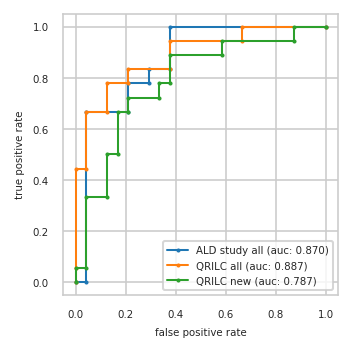

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.000 0.056
2          0.042 0.667     0.000 0.444     0.042 0.056
3          0.208 0.667     0.042 0.444     0.042 0.333
4          0.208 0.778     0.042 0.667     0.125 0.333
5          0.292 0.778     0.125 0.667     0.125 0.500
6          0.292 0.833     0.125 0.778     0.167 0.500
7          0.375 0.833     0.208 0.778     0.167 0.667
8          0.375 1.000     0.208 0.833     0.208 0.667
9          1.000 1.000     0.375 0.833     0.208 0.722
10           NaN   NaN     0.375 0.944     0.333 0.722
11           NaN   NaN     0.667 0.944     0.333 0.778
12           NaN   NaN     0.667 1.000     0.375 0.778
13           NaN   NaN     1.000 1.000     0.375 0.889
14           NaN   NaN       NaN   NaN     0.583 0.889
15           NaN   NaN       NaN   NaN     0.583 0.944
16           NaN   NaN       NaN   NaN     0.875 0.944
17           NaN   NaN       NaN   NaN     0.875 1.000
18           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,G3V4U0;G3XA98;Q9UBX5,P60709;P63261,P06732
2,A0A0B4J1V0,P10636-2;P10636-6,A0A0J9YW36;Q9NZ72;Q9NZ72-2
3,P61981,A0A0A0MRJ7;P12259,P10644;P10644-2
4,Q99983,P14174,P30048;P30048-2
5,P04075,P61981,Q14894
6,P14174,P04075,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
7,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,D6R956;P09936
8,P08294,P00338;P00338-3,P31321


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


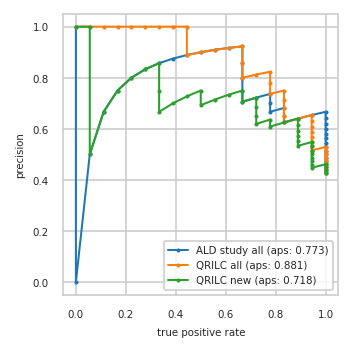

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.630 0.944     0.593 0.889
16         0.654 0.944     0.654 0.944     0.615 0.889
17         0.640 0.889     0.640 0.889     0.640 0.889
18         0.625 0.833     0.625 0.833     0.625 0.833
19         0.652 0.833     0.652 0.833     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.667 0.778     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.650 0.722
23         0.737 0.778     0.737 0.778     0.684 0.722
24         0.722 0.722     0.778 0.778     0.722 0.722
25         0.706 0.667     0.824 0.778     0.706 0.667
26         0.750 0.667     0.812 0.722     0.750 0.667
27         0.800 0.667     0.800 0.667     0.733 0.611
28         0.857 0.667     0.857 0.667     0.714 0.556
29         0.923 0.667     0.923 0.667     0.692 0.500
30         0.917 0.611     0.917 0.611     0.750 0.500
31         0.909 0.556     0.909 0.556     0.727 0.444
32         0.900 0.500     0.900 0.500     0.700 0.389
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.857 0.333
36         0.833 0.278     1.000 0.333     0.833 0.278
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


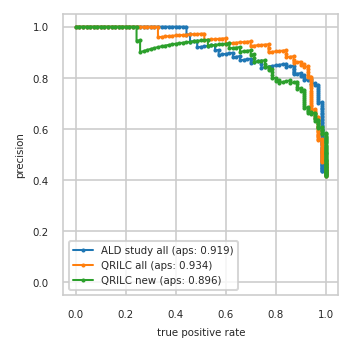

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


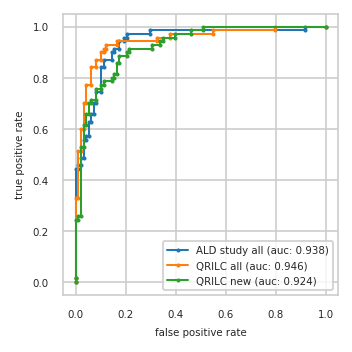

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}